# Assignment 1 Computational Stats
## Building causal inference graphs
Carlos Soto Garcia Delgado i6216792
Kristian ...
Ayse...
Ali...
Philip...

In [16]:
import pandas as pd
import numpy as np
from IPython.display import Image
from matplotlib import pyplot as plt

We read the dataframe and inspect it

In [14]:
df = pd.read_csv('a1_data.csv')

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'B'}>,
        <AxesSubplot:title={'center':'C'}>],
       [<AxesSubplot:title={'center':'D'}>,
        <AxesSubplot:title={'center':'E'}>,
        <AxesSubplot:title={'center':'F'}>],
       [<AxesSubplot:title={'center':'G'}>,
        <AxesSubplot:title={'center':'H'}>,
        <AxesSubplot:title={'center':'I'}>],
       [<AxesSubplot:title={'center':'J'}>,
        <AxesSubplot:title={'center':'K'}>, <AxesSubplot:>]], dtype=object)

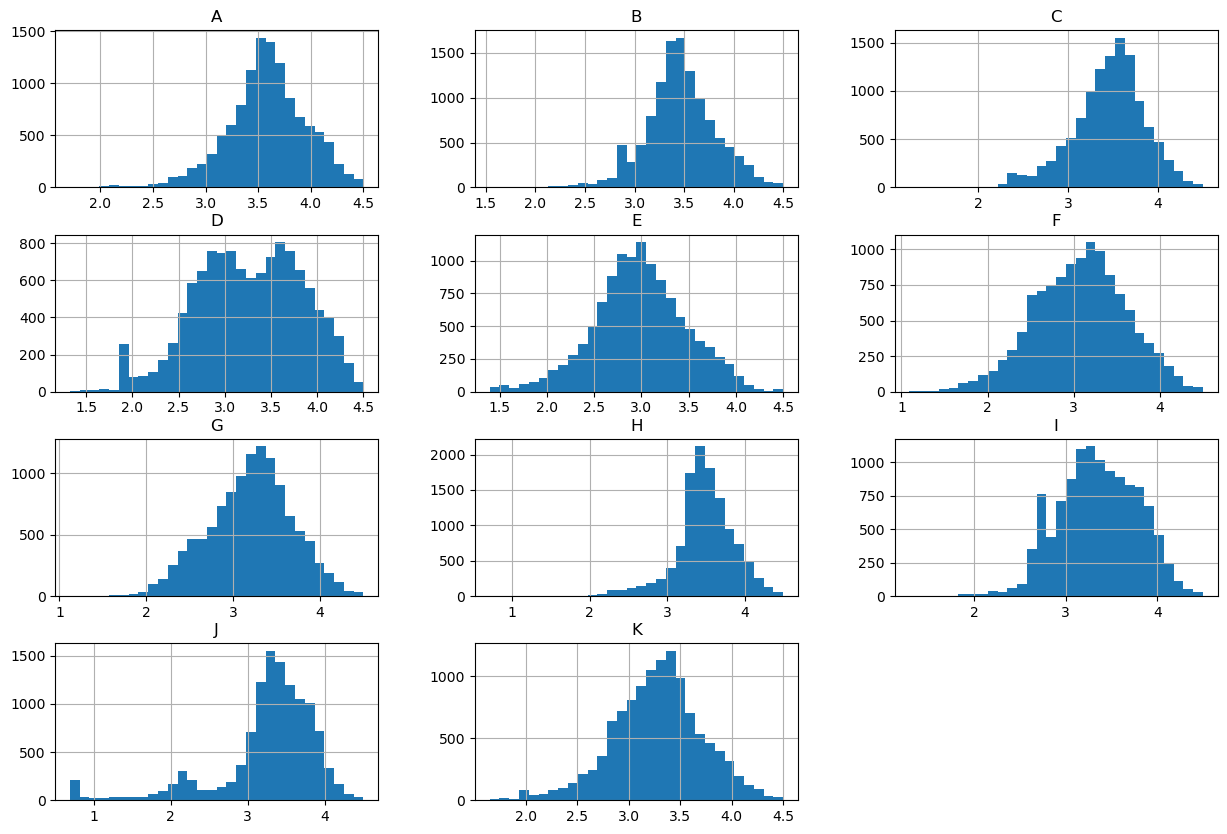

In [3]:
df.hist(bins=30, figsize=(15, 10))

## Assumptions

We will make the following assumptions:
- Makes no assumptions on the distribution of the data
- Assumes causal sufficiency: there are no unobserved confounders for any of the variables in the graph
- Assumes acyclicity: there are no cycles in the graph
- Faithfulness assumption: variables that are causally connected in a particular way in the graph are probabilistically dependent.

## Algorithm: PC
### An Algorithm for Fast Recovery of Sparse Causal Graphs (Spirtes and Glymour 1991)

### Explanation. 
#### Overview: How does the algorithm work?

Let´s say we have 5 variables: A, B C, D and E <br>The process that generates the data can be represented by the following graph, which we want to find:

In [6]:
Image(url="pics/4.png", width=300, height=300)

- Pc is a Constraint-based method <br>
- The algorithms has different steps:<br>
    1. Start with a complete undirected graph
    2. Identify the skeleton (the undirected edges in our graph)
    3. Identify the graph inmoralities. (A graph immorality occurs when a child has two or more parents that without dependencies between them)
    4. Orient the rest of the edges using our discoveries from step 2. We orient edges that are incident in colliders.
    <br><br>

Now, we will go through each step in more detail:

#### Step 1. Start with a complete undirected graph


We start by constructing a directed graph where each variable is a node and all nodes are connected to each other by undirected graphs.


In [8]:
Image(url="pics/1.png", width=300, height=300)


#### Step 2. Identify the skeleton of the graph (undirected edges)

The idea is that we perform independence tests between variables in order to remove edges. <br>
More specifically, we start conditioning on the empty set and we perform independence tests between two variables X and Y. If X and Y are independent, we remove the edge from the graph. We start conditioning on the empty set but we increase the set of the conditioning set later.<br>

Let´s show how this step works with our example:




1. We test whether A and B are independent

\begin{align}
\newcommand{\indep}{\perp \!\!\! \perp}
 X \indep Y | \{\} ?
\end{align}

We see that A and B are independent, so we can remove that edge. No other pair of nodes is independent given the empty set

In [5]:
Image(url="pics/2a.png", width=300, height=300)


2. We condition on sets of nodes when testing for independence. For the sake of the explanation we condition on C. We test whether: <br> <br> 
\begin{align}
\newcommand{\indep}{\perp \!\!\! \perp}
\forall \text{  other pairs  }  (X,Y) , X \indep | \{C\}  
\end{align}
<br>

If we condition on C, A and D are independent, same for A-E, B-D and B-E. So, we remove those edges. We obtain the follwoing skeleton graph:


In [7]:
Image(url="pics/2.png", width=300, height=300)

#### Step 3: Identify the inmoralities
In this step for any path X-Z-Y were the follwoing hold:
1. There is no edge between X and Y
2. Z was not in the conditioning set that makes X and Y conditionally independent

Then, X-Z-Y forms an inmorality*



\*A graph immorality occurs when a child has two or more parents that without dependencies between them 

In our example: 
- Take edges A and B
- There is no edge between A and B
- C was not in the conditioning set that made A and B independent


In [8]:
Image(url="pics/3.png", width=300, height=300)

#### Step 4: Orient thethe rest of the edges. (Qualifying edges incident on colliders)

The idea is that we use all discovered inmoralities in step 3 to orient the rest of the edges.<br>
In our example: If there was a directed edge from D to C, we would have discovered it in step 2. Hence, the edge neeeds to be directed from C to D. 
Same thing from C to E.
<br><br><br> We are done!

In [9]:
Image(url="pics/4.png", width=300, height=300)

## Running the algorithm in our dataset

In [23]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
from causallearn.utils.GraphUtils import GraphUtils
import numpy as np
import pydot

  0%|          | 0/11 [00:00<?, ?it/s]

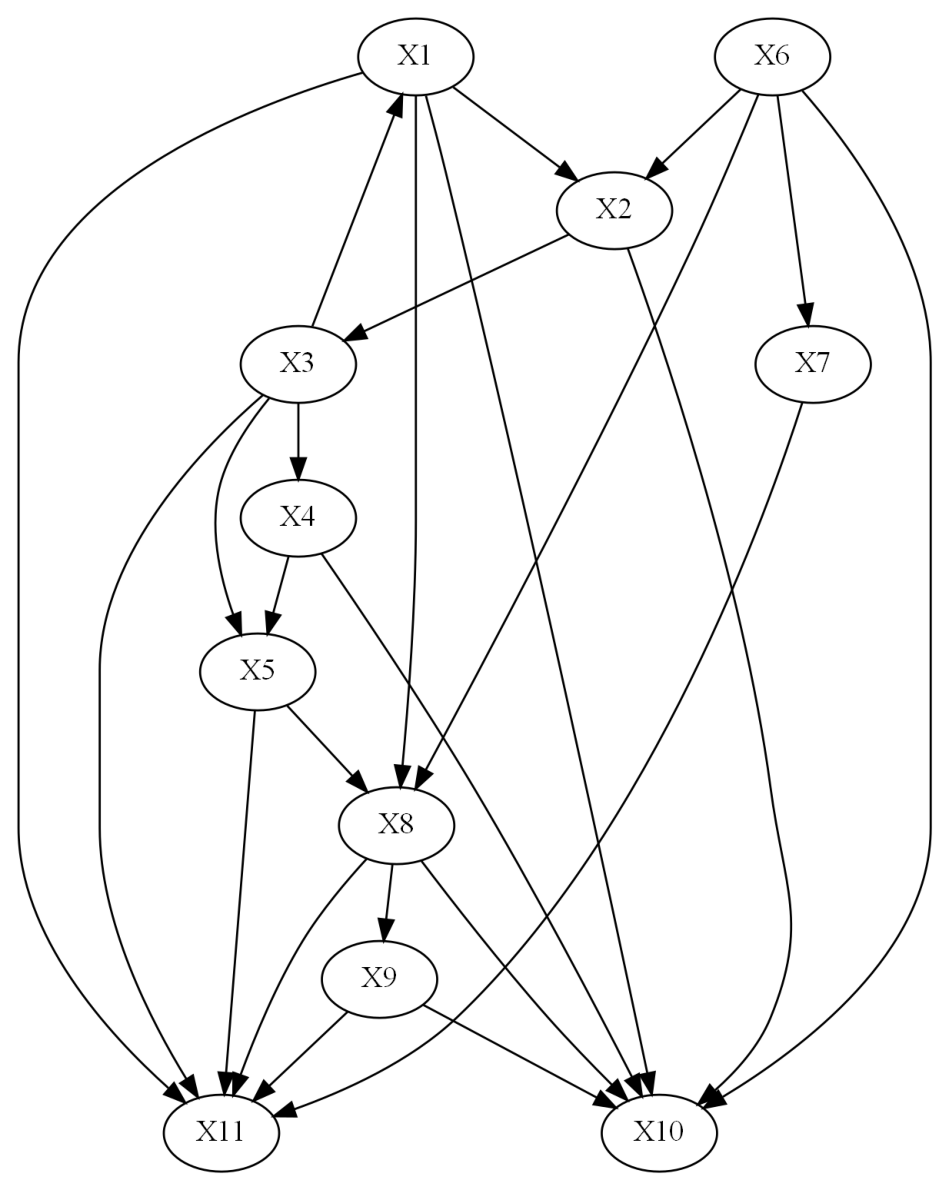

In [26]:
#https://blog.ah.technology/applying-pc-and-directlingam-for-causal-discovery-5d9066cd8dfc
def apply_causal_learn_pc(df):
    data_list = []

    for column in df.columns:
        data_list.append(df[column].to_numpy())

    data = np.array(data_list).T
    cg = pc(data, 0.05, fisherz, True, 0, 0)

    cg.draw_pydot_graph()  # visualization using pydot
    #pyd = GraphUtils.to_pydot(cg.G)
    #pyd.write_png('graph_test.png')

apply_causal_learn_pc(df)

## Limits of the procedure:


In real life we may encounter violations of our assumption:
    - No causal efficiiency. This means some cofounder variables are not observable. This will be the case in many real life settings. Even if we can have access to all the cofounder variables, we will not know it.
    -There may be no acyclicity in the data.
<br><br>  Additionnally, conditional independence testing is HARD.
PC relies on accurate conditional independence testing. If this is not accurate, then the method will not be.
<br> <br> The more data we have, the more accurate the conditional independence test will be. Hence this method may not be considered for 'small' data problems.

<br><br>In the original paper, the authors report an error rate of 14% on the direction of the edges on the ALARM dataset with no prior ordering information. This method is fast, simple, scalable and does not make too many assumptions on the distribution of the data. However, depending on our use case, it could be worth checking other methods that have a lower error and/or 